In [1]:
# This module runs a MonteCarlo meethod 
# using the EMCEE library
# Poliastro and Astropy.


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astropy import units as u
from astropy import time
from astropy.coordinates import representation



In [2]:
from poliastro.bodies import Earth
from poliastro.twobody import Orbit


In [4]:
# from poliastro.plotting.static import StaticOrbitPlotter  # POLIASTRO v0.11?
from poliastro.plotting import OrbitPlotter, plot # Poliastro v 0.9.1

In [5]:
import emcee
import corner
#import timeit

In [6]:
emcee.__version__

'2.2.1'

In [7]:
corner.__version__

'2.0.1'

In [8]:


R_earth = 6378.1    # km
v_c     = 300000    # km/s

N_t     = 10        # Tota number of times that satellite signal is measured by each GS
deltaT  = 20        # seconds. Time interval between measurements


def distance(a, b):
    x0 = a[0]
    x1 = a[1]
    x2 = a[2]
    
    y0 = b[0]
    y1 = b[1]
    y2 = b[2]
    
    dist = (x0-y0)**2 + (x1-y1)**2 + (x2-y2)**2
    dist = dist**0.5
    return dist


def rel_vel_to_base(r, v, Base):
        """
        Returns the relative speed of the satellite to
        some ground location. This velocity is 
        positive if the satellite is going towards
        the ground location, negative if is going 
        outwards.
        """
        
        x1 = Base[0]
        y1 = Base[1]
        z1 = Base[2]
    
        x_r = r[0] - x1
        y_r = r[1] - y1
        z_r = r[2] - z1  

        d = ( x_r ** 2 + y_r ** 2 + z_r ** 2 )**0.5
    
        ux  = x_r / d
        uy  = y_r / d
        uz  = z_r / d
    
        u = np.array([ux, uy, uz])
        
        return np.inner(-u,v)


# To synchronize the first measurement.
EPOCH = time.Time('2019-04-10 12:00:00.0' , format='iso')

### Ground Base positions (in cartesian coordinates)

a = np.array([6206.87748242, -2681.198044  ,   604.2233833])
a /= np.linalg.norm(a)
a = a * R_earth


b = np.array([6250.0, -2700.0, 500.0])
b /= np.linalg.norm(b)
b = b * R_earth


c = np.array([6100.0, -2800.0, 500.0])
c /= np.linalg.norm(c)
c = c * R_earth

d = np.array([5800.0, -2500.0, 200.0])
d /= np.linalg.norm(d)
d = d * R_earth


BaseA = a
BaseB = b
BaseC = c
BaseD = d



MD_path = "measured_data/"

MD_filename = "A.dat"
data = np.loadtxt(MD_path+MD_filename)
T_a = data[:,0]
A   = data[:,1]

T = data[:,0]


MD_filename = "B.dat"
data = np.loadtxt(MD_path+MD_filename)
T_b = data[:,0]
B   = data[:,1]

MD_filename = "C.dat"
data = np.loadtxt(MD_path+MD_filename)
T_c = data[:,0]
C   = data[:,1]

MD_filename = "D.dat"
data = np.loadtxt(MD_path+MD_filename)
T_d = data[:,0]
D   = data[:,1]

In [19]:
my_orbit = Orbit.from_classical(Earth, 
                                (R_earth+409)*u.km , 
                                0.00015*u.one, 
                                51 * u.deg, 
                                332 * u.deg, 
                                180 * u.deg,
                                -179 * u.deg)



In [29]:
my_orbit.

Earth (♁)

In [32]:
def log_likelihood(param):
    """
    param = [a, ecc, inc, raan, argp, nu]
    
    Returns the log_Likelihood chi2 as the sum of squares
    of differences between real data and MC-data
    """
    a, ecc, inc, raan, argp, nu = param

    ### Limit the parameter space ###
    
    if a < R_earth + 100:
        return -numpy.inf
    
    if (ecc < 0) or (ecc > 1) :
        return -numpy.inf
    
    if (inc < 0) or (inc > 180):
        return -numpy.inf
    
    if abs(raan) > 360:
        return -numpy.inf
    
    if abs(nu) > 180:
        return -numpy.inf
    
    a    =   a  * u.km
    ecc  = ecc  * u.one
    inc  = inc  * u.degree
    raan = raan * u.deg
    argp = argp * u.deg
    nu   = nu   * u.deg
    
    MCsat = Orbit.from_classical(Earth, a=a, ecc=ecc, inc=inc, raan=raan, argp=argp, nu=nu, epoch=EPOCH)
    
    #MCsat.classical()
    
    MCsat_r      = []
    MCsat_v      = []
    MCsat_t      = []
    
    MCsatV_rel_A = []
    MCsatV_rel_B = []
    MCsatV_rel_C = []
    MCsatV_rel_D = []
    
    for i in range(N_t):
        aux = MCsat.propagate(deltaT * i * u.second)
        MCsat_r.append(aux.r )
        MCsat_v.append(aux.v )
        MCsat_t.append(aux.epoch.unix)
        
    MCsat_r = np.array(MCsat_r)
    MCsat_v = np.array(MCsat_v)
    
    MCsat_A=[]
    MCsat_B=[]
    MCsat_C=[]
    MCsat_D=[]

    for t in range(N_t):
        MCsat_A.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseA) )
        MCsat_B.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseB) )
        MCsat_C.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseC) )
        MCsat_D.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseD) )

    MCsat_A = np.array(MCsat_A)
    MCsat_B = np.array(MCsat_B)
    MCsat_C = np.array(MCsat_C)
    MCsat_D = np.array(MCsat_D)

    
    chi2 = 0
    sigma = np.log(2*np.pi)
    for t in range(len(T)):
        chi2 += (MCsat_A[i]-A[i])**2 + sigma
        chi2 += (MCsat_B[i]-B[i])**2 + sigma
        chi2 += (MCsat_C[i]-C[i])**2 + sigma
        chi2 += (MCsat_D[i]-D[i])**2 + sigma
    #print("Log Likelihood: ", chi2)
    return chi2

In [33]:
param = [R_earth+409, 0.00015, 51, 332, 180, -179 ]

log_likelihood(param)

149.70899336046324

In [40]:
### Initialize EMCEE random walkers

MCMC_steps = 20

nwalkers, ndim = 20, 6
p0 = np.zeros((nwalkers,ndim))


theta = [R_earth + 500, 0.001, 0, 0, 0, 0]

for i in range(nwalkers):
    p0[i,0] = theta[0] * np.random.normal(1, 0.08)
    p0[i,1] = theta[1] + 0.1 * np.random.rand()
    p0[i,2] = theta[2] * np.random.normal(0, 30)
    p0[i,3] = 360 * np.random.rand()
    p0[i,4] = 360 * np.random.rand()
    p0[i,5] = 360 * np.random.rand()

In [41]:
import numpy

#toc = timeit.default_timer()

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
pos, prob, state = sampler.run_mcmc(p0, MCMC_steps)

#tic = timeit.default_timer()
#print("Time elapsed: ", tic -toc, "seconds")

In [42]:
samples = sampler.chain[:,5:,:].reshape((-1, ndim))
#clock = timeit.time.time()

In [43]:
MC_path = "monte_carlo_chain_register/"
MC_filename = "mc_steps_{}_random_walkers_{}_{}_.dat".format(MCMC_steps, nwalkers, clock)
np.savetxt(MC_path+MC_filename, samples)

MC_filename = "mc_steps_{}_random_walkers_{}_{}_.accepance".format(MCMC_steps, nwalkers, clock)
np.savetxt(MC_path+MC_filename, sampler.acceptance_fraction)

NameError: name 'clock' is not defined

In [44]:
corner.corner(samples)

ValueError: It looks like the parameter(s) in column(s) 2 have no dynamic range. Please provide a `range` argument.

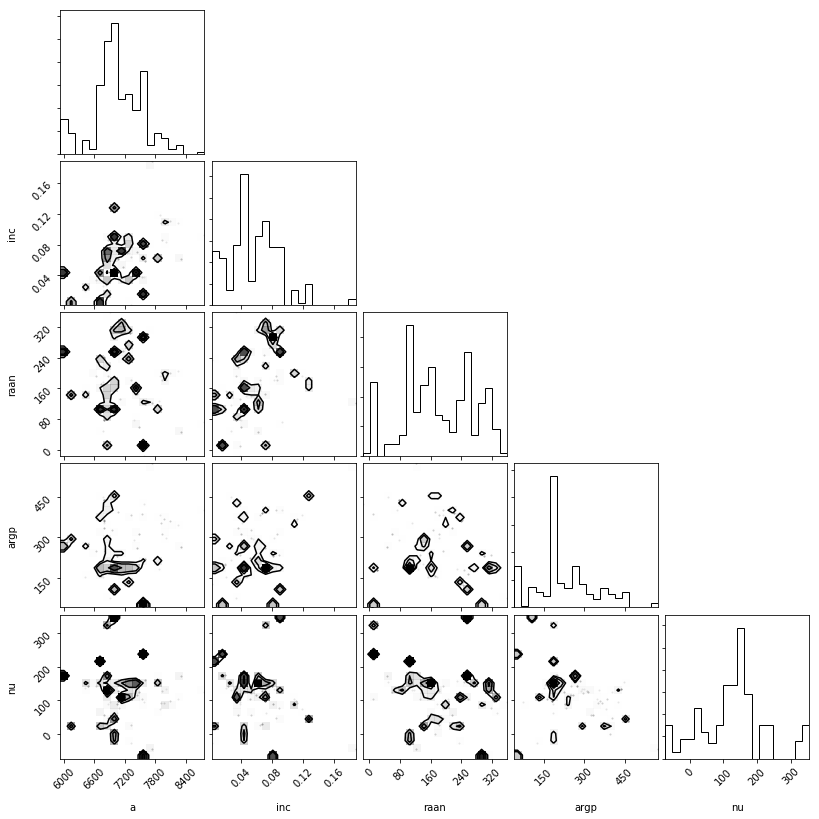

In [45]:
samples2 = np.delete(samples, 2, axis=1)
fig = corner.corner(samples2, labels=["a", "inc", "raan", "argp", "nu"])

In [86]:
sampler.lnprobability.shape

(500, 10)

In [52]:
v = (2*np.pi*R_earth * u.km /(86400 * u.s))
v.to(u.km/u.h)

<Quantity 1669.78267532 km / h>

In [54]:
v.to(u.m/u.s)

<Quantity 463.82852092 m / s>

In [55]:
import astropy.coordinates

In [57]:
astropy.coordinates.EarthLocation()

astropy.coordinates.earth.EarthLocation